# TimeSeries Citi Bike Analysis

This notebook will look at a timeseries analysis using the New York, Citi Bike data.  The goal is to predict based on the day of the week and the time of the day, how many people will rent bikes from a particular location.

The focus with this notebook will be on timeseries data and how to make predictions with timeseries data.

Not every model can be used with timeseries data when predicting future events.  In addition, it is not always possible to just use the timestamp of the date/time of the event.  Sometimes you need to look at adding dummy variables for day of the week, holidy, weekend, etc.

The citibike data is in the data directory in a file named:  *citibike.csv*

This is a summary of:
### Introduction to Machine Learning with Python: A Guide for Data Scientists
- Book by Andreas Muller and Sarah Guido is a very consumeable guide to machine learning with great insight into the field.
- Chapter 4, Utilizing Expert Knowledge.


In [1]:
import mglearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

In [2]:
citibike = mglearn.datasets.load_citibike()

In [3]:
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

As you can see, the data consists only of a datatime column and the number of bikes rented in the 3 hour bucket of time.

Lets create a line plot of the starttime and the number of bikes rented:


Text(0,0.5,'Rentals')

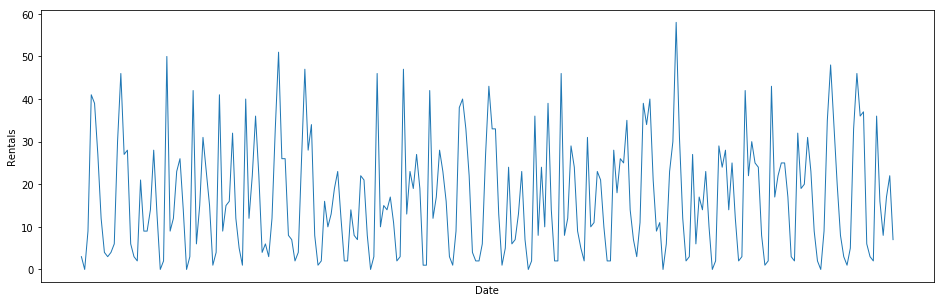

In [4]:
plt.figure(figsize=(16,5))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks.astype("int"), xticks.strftime("%a %m-%d"), rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

Visualizing the data, we can see various patterns for day/night, weekday/weekend.  When performing a prediction task on a time series, we usually want to learn from the past to predict the future.  The means when we do the train_test_split, we **cannot** take a random sample but instead we want to take all data up to a particular point in time as the training data, and all data past that point in time as test data.  

Looking at the data set, as it is, there is a single feature: *startime*.  

As a first attempt, lets use the startime in the unix timestamp format and try to train a model.


### Use starttime as a posix milliseconds from Janary 1970

In [5]:
# Extract target values:
y = citibike.values

# convert the starttime to posix time by dividing by 10**9
# the starttime is the index column, and we want to convert to an integer value
# once we have the integer values, reshape to have all of the rows and a single column
# then divide by 10**9
X = citibike.index.astype("int64").values.reshape(-1,1) // 10**9

There are 248 samples.  We would like to hold out some for training and some for test.

In [6]:
print(y.shape)
print(X.shape)

(248,)
(248, 1)


In [7]:
# use the first 184 for training data
n_train = 184

In [8]:
# Function to evaluate and plot a regressor on a given feature set.
# This function will take the feature set and the target set and create a train/test split.  
# It will then use the regressor model to evaluate how the model is doing and plot the results.

# NOTE: this is taken verbatime from the reference above:
# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array 
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(16, 5))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

## RandomForestRegressor

Lets try to use the RandomForestRegressor to predict the future bike rentals.  

Test-set R^2: -0.04


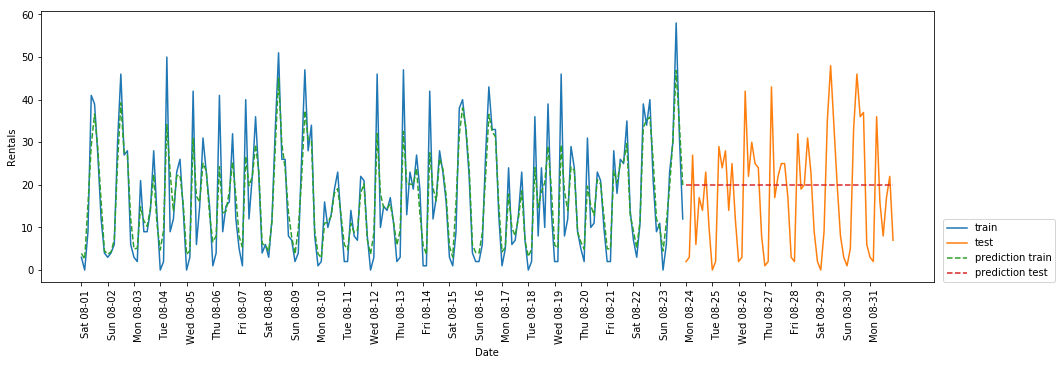

In [9]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, random_forest)

Notice the flat line for the *prediction test* which means the RandomForestRegressor predicted a constant value which is the last value predicted.

This is a very important feature, or limitation, of Tree based models.  Trees, including the RandomForest, 

**CANNOT EXTRAPOLATE TO FEATURE RANGES OUTSIDE THE TRAINING SET**

Because this is a time service, our training set includes past values, the but the test set are all future values.  Therefore we **cannot** use a RandomForestRegressor.



## Feature Engineering

There is really nothing to be learned from the starttime by itself - but maybe there is something that can be learned from the day of week and time of day.

Looking at the data we can see that *time of day* and *day of week* seem to be important attributes of the data set.  We can see the fluctuation in the number of rentals.

Lets create a couple of new features.

Lets pull out just the hour from the start

In [10]:
X_hour = citibike.index.hour.values
print(X_hour)

[ 0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21  0  3  6  9 12 15 18 21
  0  3  6  9 12 15 18 21]


We can see very clearly the 3 hour buckets that the data was aggregated around. 

Now, lets see how the prediction if we use the hour of day as the feature.

Before we can use X_hour in the model, notice that is is an array and we really need it to be a column, so we have to reshape 

Notice that we are still going to use the RandomForestRegressor because we are switching from a timestamp as the target feature, to new, non-timebased, features

In [11]:
# reshape all rows, 1 column
X_hour = X_hour.reshape(-1,1)
print(X_hour)

[[ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18]
 [21]
 [ 0]
 [ 3]
 [ 6]
 [ 9]
 [12]
 [15]
 [18

Test-set R^2: 0.60


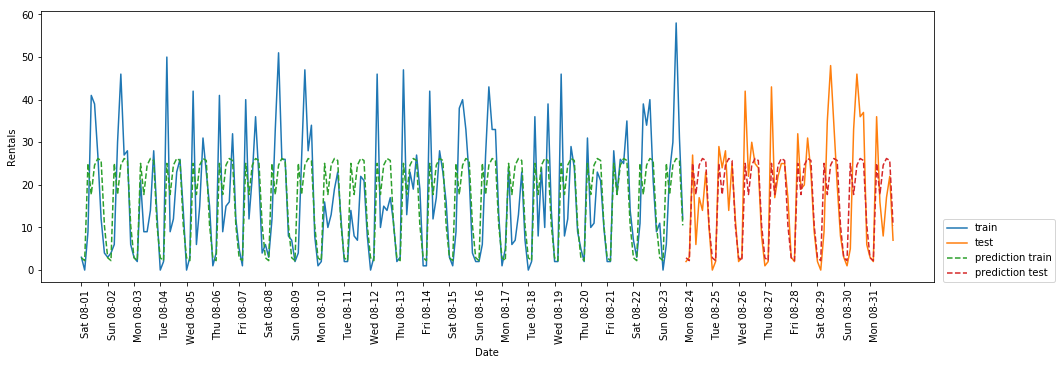

In [12]:
# target = hour of day
# number of rentals in that hour
# regressor is a RandomForestRegressor
eval_on_features(X_hour, y, random_forest)

We can see that the R^2 is much better, but the model misses the weekly pattern.  In particular it really misses on Saturday and Sunday.  

So now we might need to look at the day of the week.  

In [13]:
X_day_of_week = citibike.index.dayofweek.values
print(X_day_of_week)

[5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4
 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0]


This is a collection of the numeric day of the week, but again we need to have a target column.

In [14]:
# reshape the data to include all of the rows, and a single column
X_day_of_week = X_day_of_week.reshape(-1,1)
print(X_day_of_week)

[[5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [6]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]


Now we can stack the two target arrays into a single table / matrick


In [15]:
X_hour_week = np.hstack([X_day_of_week, X_hour])
print(X_hour_week)

[[ 5  0]
 [ 5  3]
 [ 5  6]
 [ 5  9]
 [ 5 12]
 [ 5 15]
 [ 5 18]
 [ 5 21]
 [ 6  0]
 [ 6  3]
 [ 6  6]
 [ 6  9]
 [ 6 12]
 [ 6 15]
 [ 6 18]
 [ 6 21]
 [ 0  0]
 [ 0  3]
 [ 0  6]
 [ 0  9]
 [ 0 12]
 [ 0 15]
 [ 0 18]
 [ 0 21]
 [ 1  0]
 [ 1  3]
 [ 1  6]
 [ 1  9]
 [ 1 12]
 [ 1 15]
 [ 1 18]
 [ 1 21]
 [ 2  0]
 [ 2  3]
 [ 2  6]
 [ 2  9]
 [ 2 12]
 [ 2 15]
 [ 2 18]
 [ 2 21]
 [ 3  0]
 [ 3  3]
 [ 3  6]
 [ 3  9]
 [ 3 12]
 [ 3 15]
 [ 3 18]
 [ 3 21]
 [ 4  0]
 [ 4  3]
 [ 4  6]
 [ 4  9]
 [ 4 12]
 [ 4 15]
 [ 4 18]
 [ 4 21]
 [ 5  0]
 [ 5  3]
 [ 5  6]
 [ 5  9]
 [ 5 12]
 [ 5 15]
 [ 5 18]
 [ 5 21]
 [ 6  0]
 [ 6  3]
 [ 6  6]
 [ 6  9]
 [ 6 12]
 [ 6 15]
 [ 6 18]
 [ 6 21]
 [ 0  0]
 [ 0  3]
 [ 0  6]
 [ 0  9]
 [ 0 12]
 [ 0 15]
 [ 0 18]
 [ 0 21]
 [ 1  0]
 [ 1  3]
 [ 1  6]
 [ 1  9]
 [ 1 12]
 [ 1 15]
 [ 1 18]
 [ 1 21]
 [ 2  0]
 [ 2  3]
 [ 2  6]
 [ 2  9]
 [ 2 12]
 [ 2 15]
 [ 2 18]
 [ 2 21]
 [ 3  0]
 [ 3  3]
 [ 3  6]
 [ 3  9]
 [ 3 12]
 [ 3 15]
 [ 3 18]
 [ 3 21]
 [ 4  0]
 [ 4  3]
 [ 4  6]
 [ 4  9]
 [ 4 12]
 [ 4 15]
 [ 4 18]
 

Now we can evaluate the model based on the **hour of day** and **day of week** to see if we can pick up on the changes throughout the week.

Test-set R^2: 0.84


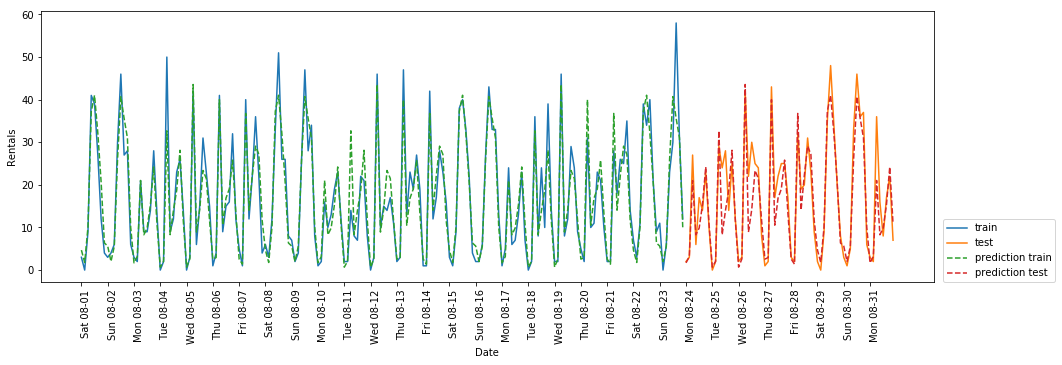

In [16]:
eval_on_features(X_hour_week, y, random_forest)

Notice the R^2 has jumped to 0.84 and the model shows pretty good predictive performance as can been seen in the chart.  The dotted lines are the prediction lines, and they match very well to the actual lines.

## Can we use LinearRegression model

In this case, as the target variables stand we cannot.  The reason is because the **hour of day** and **day of week** are numbers and are considered continuous variables by a linear model.   We can however create a one-hot-encoding of the **hour of day** and **day of week**


/Users/patryan/Development/mygithub/machinelearning101/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Test-set R^2: 0.13


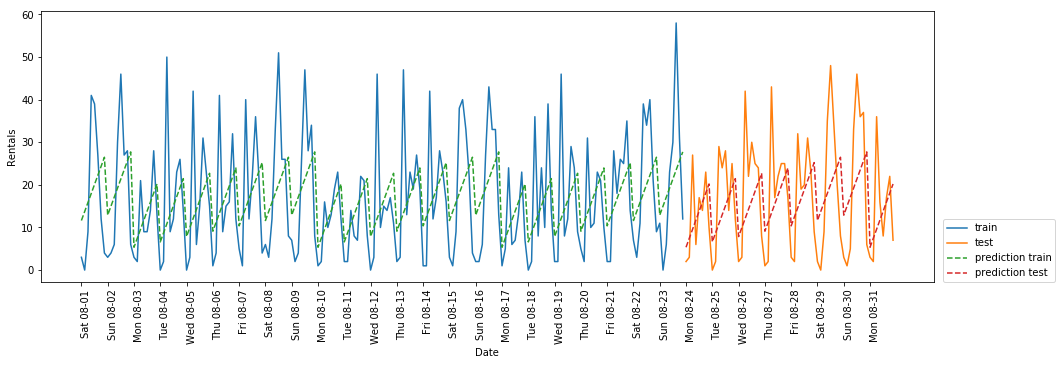

In [17]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
eval_on_features(X_hour_week, y, lr)

You can see that the model did **not** behave well.  The R^2 dropped to 0.13 and you can see the predictions do not match the actual.

Now lets create categorical target variables.

In [18]:
# Reminder of what X_hour_week looks like
print(X_hour_week.shape)
print(X_hour_week)

(248, 2)
[[ 5  0]
 [ 5  3]
 [ 5  6]
 [ 5  9]
 [ 5 12]
 [ 5 15]
 [ 5 18]
 [ 5 21]
 [ 6  0]
 [ 6  3]
 [ 6  6]
 [ 6  9]
 [ 6 12]
 [ 6 15]
 [ 6 18]
 [ 6 21]
 [ 0  0]
 [ 0  3]
 [ 0  6]
 [ 0  9]
 [ 0 12]
 [ 0 15]
 [ 0 18]
 [ 0 21]
 [ 1  0]
 [ 1  3]
 [ 1  6]
 [ 1  9]
 [ 1 12]
 [ 1 15]
 [ 1 18]
 [ 1 21]
 [ 2  0]
 [ 2  3]
 [ 2  6]
 [ 2  9]
 [ 2 12]
 [ 2 15]
 [ 2 18]
 [ 2 21]
 [ 3  0]
 [ 3  3]
 [ 3  6]
 [ 3  9]
 [ 3 12]
 [ 3 15]
 [ 3 18]
 [ 3 21]
 [ 4  0]
 [ 4  3]
 [ 4  6]
 [ 4  9]
 [ 4 12]
 [ 4 15]
 [ 4 18]
 [ 4 21]
 [ 5  0]
 [ 5  3]
 [ 5  6]
 [ 5  9]
 [ 5 12]
 [ 5 15]
 [ 5 18]
 [ 5 21]
 [ 6  0]
 [ 6  3]
 [ 6  6]
 [ 6  9]
 [ 6 12]
 [ 6 15]
 [ 6 18]
 [ 6 21]
 [ 0  0]
 [ 0  3]
 [ 0  6]
 [ 0  9]
 [ 0 12]
 [ 0 15]
 [ 0 18]
 [ 0 21]
 [ 1  0]
 [ 1  3]
 [ 1  6]
 [ 1  9]
 [ 1 12]
 [ 1 15]
 [ 1 18]
 [ 1 21]
 [ 2  0]
 [ 2  3]
 [ 2  6]
 [ 2  9]
 [ 2 12]
 [ 2 15]
 [ 2 18]
 [ 2 21]
 [ 3  0]
 [ 3  3]
 [ 3  6]
 [ 3  9]
 [ 3 12]
 [ 3 15]
 [ 3 18]
 [ 3 21]
 [ 4  0]
 [ 4  3]
 [ 4  6]
 [ 4  9]
 [ 4 12]
 [ 4 15]
 

# OneHotEncoding

Instead of using the *hour of day* and *day of week* as numerical values, convert them to OneHotEncoding so we can consider them categorical.

Lets create the OneHotEncoding

In [19]:
one_hot_encoder = OneHotEncoder()

In [20]:
X_hour_week_onehot = one_hot_encoder.fit_transform(X_hour_week).toarray()
print(X_hour_week_onehot.shape)
print(X_hour_week_onehot)

(248, 15)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]]


Notice that we now have 15 columns instead of just the 2 from the original feature set.

Lets try the same model, LinearRegression

Test-set R^2: 0.62


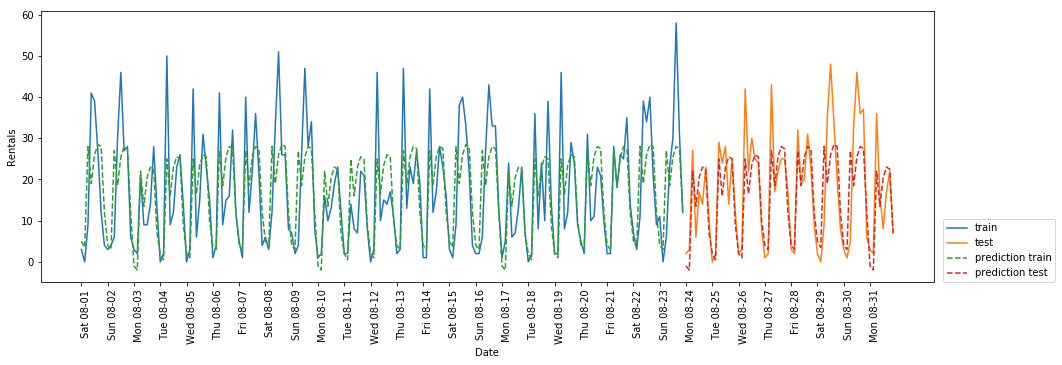

In [21]:
eval_on_features(X_hour_week_onehot, y, lr)

This is significantly better - but it suffers from the same issue as the RandomForest using just X_hour - it misses the weekly variances.

Lets look at another Linear Model - just to see if it might be model related.

Test-set R^2: 0.62


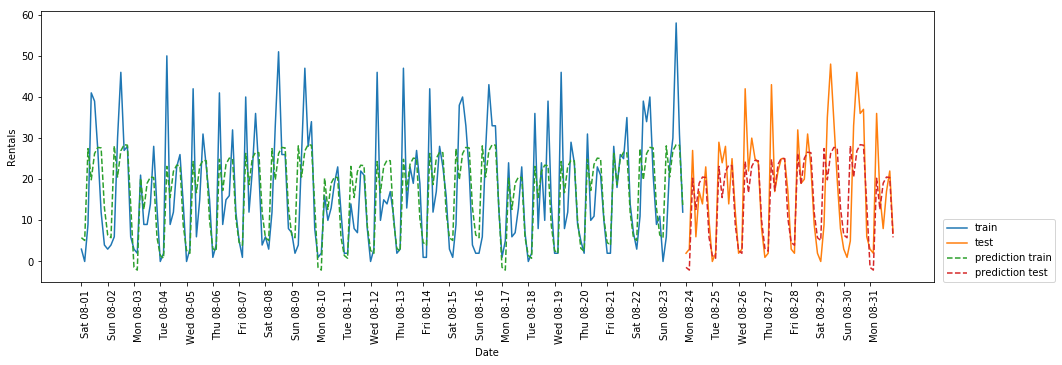

In [22]:
eval_on_features(X_hour_week_onehot, y, Ridge())

Interesting... we are not really no better than when we just looked at the hour of day.  Can we do better if we looked for PolynomialFeatures?

# PolynomialFeatures

lets try to increase the complexity of the model by increasing the polynomial degrees.

In [23]:
poly_transform = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [24]:
X_hour_onehot_poly = poly_transform.fit_transform(X_hour_week_onehot)

Test-set R^2: 0.83


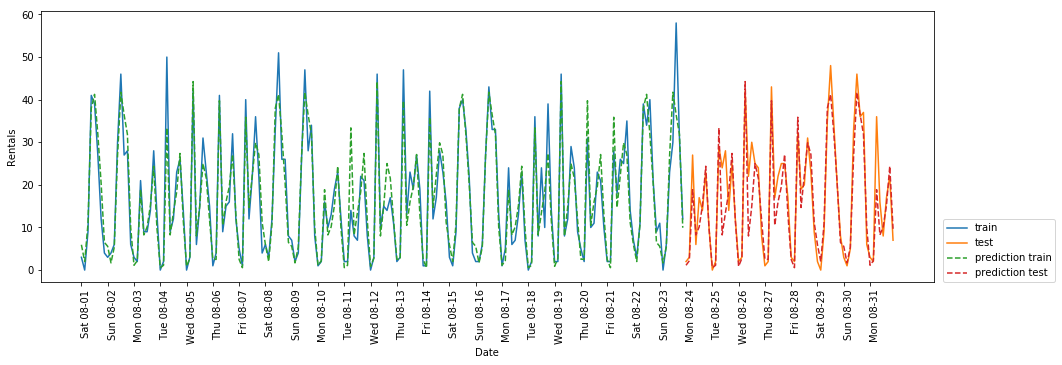

In [25]:
eval_on_features(X_hour_onehot_poly, y, lr)

Notice that we are now getting similar results using the numeric values for X_hour_week using a RandomForestRegressor.  That R^2 was 0.84.  

There are pros and cons to each model.

RandomForestRegressor requires less data preparation as we avoid the OneHotEncoding, but it might be more difficult to visualize why the prediction was made.  It also can take more time to train a RandomForestRegressor.

For the LinearRegression - there is one coefficient for each of the day and time.  LinearRegression is also generally fast to train.

# Making predictions

Lets use our RandomForest model to make predictions.  We are using this model, because the input into the model is very simple; a number from 0-6 that represents the day of the week, and a number from 0-23 that represents the hour of day.


In [26]:
# Monday = 0
# Sunday = 6

                                 # ([[day of week, hour of day]])
y_predict = random_forest.predict([[1, 18], [3, 1]])
print(f"The number of people renting bikes: {y_predict}")
print(f"On Tuesday at 6pm there are predicted {y_predict[0]:0.3f} will be rented")
print(f"On Thursday at 1am there are predicted {y_predict[1]:0.3f} will be rented")

The number of people renting bikes: [28.12795238  2.56796429]
On Tuesday at 6pm there are predicted 28.128 will be rented
On Thursday at 1am there are predicted 2.568 will be rented
